<a href="https://colab.research.google.com/github/Shihori/AI/blob/main/CNN_corona2_GitHub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/CNN-corona2/
%ls -a

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CNN-corona2
' CNN_corona2-GitHub.ipynb'   data/   model_finetuning.pt   model.pt


In [62]:
!pip install pytorch-gradcam

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import os
import scipy
import random
from tqdm import tqdm
import glob

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve

import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
from torchvision import datasets
from torchvision import transforms as transforms

from gradcam.utils import visualize_cam
from gradcam import GradCAM, GradCAMpp


In [65]:
path = "/content/drive/MyDrive/CNN-corona2"
im_fd = "/data/"

/content/drive/MyDrive/CNN-corona2/data/inactivated/120.jpg


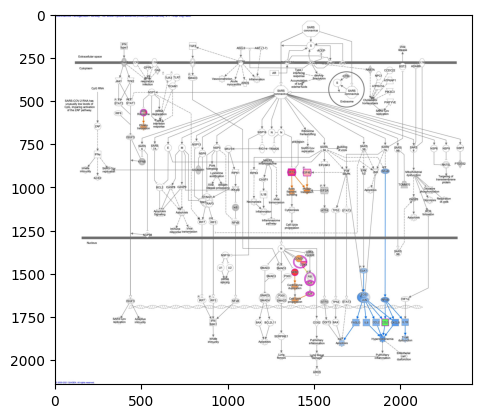

In [66]:
folder = ['inactivated','activated']
file0 = glob.glob(path + im_fd + folder[0] +"/*.jpg")[0]
print(file0)
image = Image.open(file0)
plt.imshow(image)

In [67]:
np.array(image)

array([[[251, 255, 220],
        [247, 255, 230],
        [246, 251, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[252, 255, 230],
        [248, 255, 237],
        [249, 252, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 250],
        [251, 251, 249],
        [255, 253, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[255, 247, 255],
        [255, 253, 255],
        [255, 255, 253],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 251, 255],
        [255, 249, 255],
        [251, 249, 250],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 252, 255],
        [253, 248, 254],
        [251, 247, 248],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]]

In [68]:
device = "cuda" if torch.cuda.is_available() else "cpu" # Get cpu or gpu device for training.
print(f"Using {device} device")

Using cuda device


In [69]:
image_size = 128;

In [70]:
SEED = 42

def seed_fix(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms = True
    torch.backends.cudnn.deterministic = True

    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

seed_fix(SEED)
generator = torch.Generator()
generator.manual_seed(SEED)

In [71]:
folder = ['inactivated','activated']
X = [];
y = [];
usenumber = 50
for i,folname in enumerate(folder):
    files1 = glob.glob(path + im_fd + folname +"/*.jpg");
    f_number = len(files1)
    files1, files2=torch.utils.data.random_split(files1,[usenumber,f_number - usenumber])
    for j, file in enumerate(tqdm(files1)):
        outcome = i
        image = Image.open(file)
        image = image.convert("RGB")
        image = image.resize((image_size, image_size))
        data = np.asarray(image)
        X.append(data);
        y.append(outcome)

100%|██████████| 50/50 [00:03<00:00, 15.83it/s]


In [72]:

X = np.array(X).astype(np.float32).transpose(0,3,1,2)/255
y = np.array(y)

In [73]:
Nall = X.shape[0]

In [74]:
tensor_X = torch.tensor(X, dtype=torch.float32)
tensor_y = torch.tensor(y, dtype=torch.int64)

In [75]:
dataset = torch.utils.data.TensorDataset(tensor_X,tensor_y)
n_train = int(Nall * 0.7)
n_val = int(Nall * 0.2)
n_test = Nall - n_train - n_val
train_x, val_x, test_x = torch.utils.data.random_split(dataset, [n_train, n_val,n_test])
print("train =",n_train,",validation =",n_val,",Test =",n_test)

train = 70 ,validation = 20 ,Test = 10


In [76]:
batch_size = 64
train_dataloader = DataLoader(train_x, batch_size=batch_size, shuffle=True)
val_dataloader   = DataLoader(val_x,   batch_size=batch_size, shuffle=False)
test_dataloader  = DataLoader(test_x,  batch_size=1, shuffle=False)

In [78]:
class CNN(nn.Module):
    def __init__(self, input_shape=(3,128,128),output_size=2):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv2d(in_channels=input_shape[0], out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv2 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv3 = nn.Sequential(nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.conv4 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same'),nn.ReLU(),nn.MaxPool2d(2,2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(0.2)
        self.CNN_outshape = self._get_conv_output(input_shape)
        self.linear = nn.Linear(self.CNN_outshape, output_size)
    def _get_conv_output(self, shape):
        bs = 1
        dummy_x = torch.empty(bs, *shape)
        x = self._forward_features(dummy_x)
        CNN_outshape = x.flatten(1).size(1)
        return CNN_outshape
    def _forward_features(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.dropout(x)
        x = self.flatten(x)
        return x
    def forward(self, x):
        x = self._forward_features(x)
        x = self.linear(x.flatten(1))
        return x
model = CNN().to(device)
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [79]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((image_size,image_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    transforms.RandomVerticalFlip(p=0.4),
    transforms.RandomRotation(degrees=[-7.5, 7.5])
    ]
) #Data augumentation

In [80]:

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay= 0.005)

def train(train_loader): #Training
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #data augumentation
        #images = transform(images)
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc

def valid(test_loader): #Validation
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc


acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []

In [81]:
nepoch = 300

#Fitting
for epoch in range(nepoch):
    loss, acc = train(train_dataloader)
    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.6949 acc: 0.4714 val_loss: 0.6943 val_acc: 0.4500
epoch 1, loss: 0.6859 acc: 0.4571 val_loss: 0.6949 val_acc: 0.4500
epoch 2, loss: 0.6933 acc: 0.5000 val_loss: 0.6959 val_acc: 0.4500
epoch 3, loss: 0.6926 acc: 0.4857 val_loss: 0.6966 val_acc: 0.4500
epoch 4, loss: 0.6920 acc: 0.4857 val_loss: 0.6970 val_acc: 0.4500
epoch 5, loss: 0.6943 acc: 0.4857 val_loss: 0.6973 val_acc: 0.4500
epoch 6, loss: 0.6898 acc: 0.4857 val_loss: 0.6976 val_acc: 0.4500
epoch 7, loss: 0.6940 acc: 0.4857 val_loss: 0.6979 val_acc: 0.4500
epoch 8, loss: 0.7041 acc: 0.4857 val_loss: 0.6978 val_acc: 0.4500
epoch 9, loss: 0.6829 acc: 0.4857 val_loss: 0.6978 val_acc: 0.4500
epoch 10, loss: 0.6867 acc: 0.4857 val_loss: 0.6982 val_acc: 0.4500
epoch 11, loss: 0.6880 acc: 0.4857 val_loss: 0.6988 val_acc: 0.4500
epoch 12, loss: 0.6879 acc: 0.4857 val_loss: 0.6995 val_acc: 0.4500
epoch 13, loss: 0.6944 acc: 0.4857 val_loss: 0.7002 val_acc: 0.4500
epoch 14, loss: 0.7130 acc: 0.4857 val_loss: 0.7001 val_ac

In [82]:

torch.save(model, 'model.pt')

In [85]:

model = torch.load('model.pt', weights_only=False)

正解率： 55.00000000000001 %


Text(0, 0.5, 'acc')

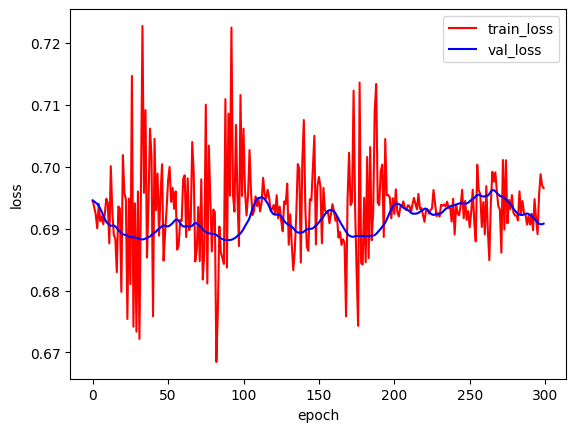

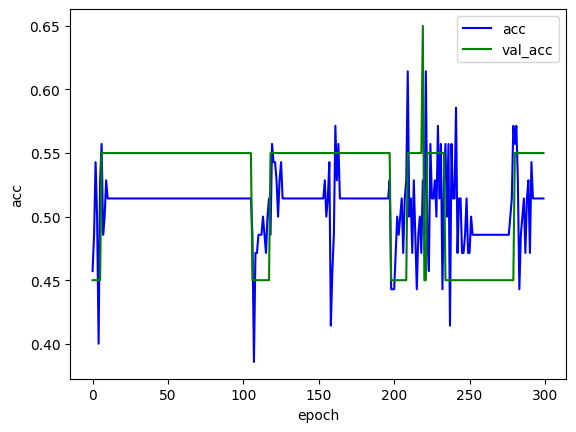

In [ ]:
print('Accuracy：',val_acc_list[-1]*100, '%')


plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')

Model Evaluation Test data

In [86]:
#For Test
def test(test_loader):
    prob = []
    pred = []
    true = []
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            lprob, predicted = outputs.max(1, keepdim=True)
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            prob = np.append(prob, scipy.special.expit(torch.Tensor.numpy(outputs[:,1].to('cpu'))))
            pred = np.append(pred, torch.Tensor.numpy(predicted.to('cpu')))
            true = np.append(true, torch.Tensor.numpy(labels.to('cpu')))
    return prob, pred, true

prob, pred, true,  = test(test_dataloader)


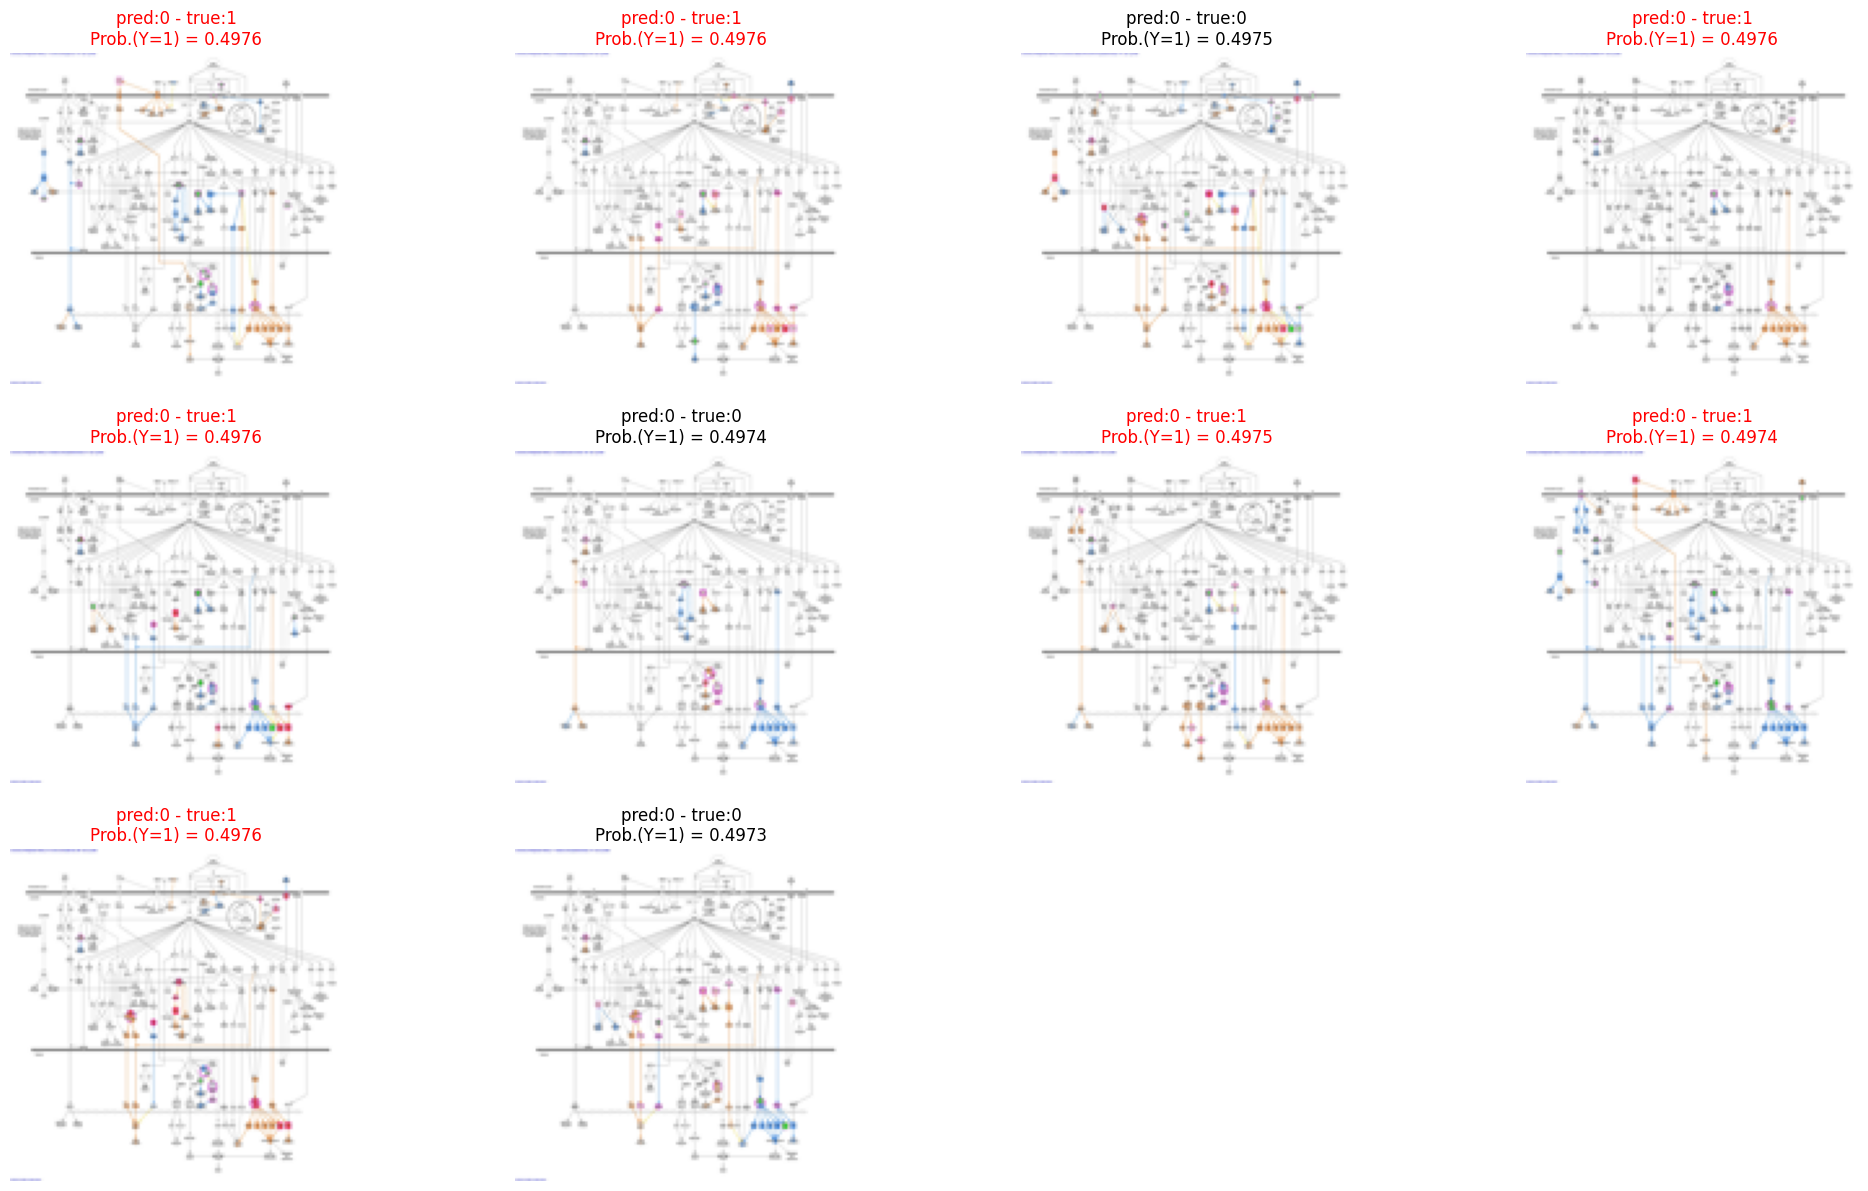

In [87]:

plt.figure(figsize = (25, 25))
for i in range(10):
    plt.subplot(5, 4, i + 1)
    plt.axis("off")
    if pred[i] == true[i]:
        plt.title("pred:"+str(pred[i].astype(np.uint8))+' - '+"true:"+str(true[i].astype(np.uint8))+'\n'+'Prob.(Y=1) = %.4f' % (prob[i]))
    else:
        plt.title("pred:"+str(pred[i].astype(np.uint8))+' - '+"true:"+str(true[i].astype(np.uint8))+'\n'+'Prob.(Y=1) = %.4f' % (prob[i]), color = "red")

    tmp = test_x[i][0].to('cpu').detach().numpy().copy()
    tmp = tmp.transpose(1, 2, 0)
    img_pil = Image.fromarray((tmp*255).astype(np.uint8))
    plt.imshow(img_pil)




In [88]:

cmat = confusion_matrix(true, pred)
print(cmat)


tn, fp, fn, tp = cmat.flatten()

acc = round((tp+tn)/(tp+tn+fp+fn),4)
sen = round(tp/(tp+fn),4)
spe = round(tn/(tn+fp),4)
ppv = round(tp/(tp+fp),4)
npv = round(tn/(tn+fn),4)
print("acc=",acc,"sen=",sen," ,spe=",spe," ,ppv=",ppv," ,npv=",npv)



[[3 0]
 [7 0]]
acc= 0.3 sen= 0.0  ,spe= 1.0  ,ppv= nan  ,npv= 0.3


<ipython-input-88-4cf69d55aa0c>:10: RuntimeWarning: invalid value encountered in scalar divide
  ppv = round(tp/(tp+fp),4)


Cutoff-value: 0.4975 Sensitivity: 0.8571 Specificity:  1.0


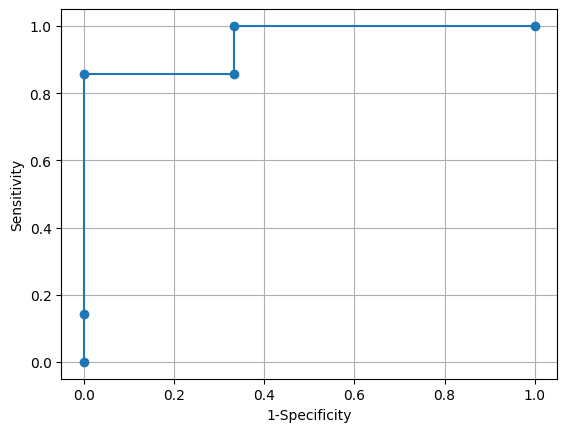

In [89]:
#ROC curve

fpr, tpr, thresholds = roc_curve(true, prob)
plt.plot(fpr, tpr, marker='o')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.grid()
#plt.savefig(path+'/roc_curve.png')

Youden_index = tpr-fpr
index = np.where(Youden_index==max(Youden_index))[0][0]

cutoff = thresholds[index]
sensitivity = tpr[index]
specificity = 1 - fpr[index]
print("Cutoff-value:",round(cutoff,4),"Sensitivity:",round(sensitivity,4),"Specificity: ",round(specificity,4))




In [90]:
#!pip install grad-cam -q
#!conda install grad-cam

Grad-CAM

In [91]:
# Grad-CAM

In [92]:
# Load the model, explicitly setting weights_only to False
model = torch.load('model.pt', weights_only=False)
model.eval()

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)

In [93]:
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.2, inplace=False)
  (linear): Linear(in_features=4096, out_features=2, bias=True)
)


In [94]:
target_layer = model.conv4[1]

In [95]:
gradcam = GradCAM(model, target_layer)

/usr/local/lib/python3.11/dist-packages/gradcam/gradcam.py:81: UserWarning: `nn.functional.upsample` is deprecated. Use `nn.functional.interpolate` instead.
  saliency_map = F.upsample(saliency_map, size=(h, w), mode='bilinear', align_corners=False)


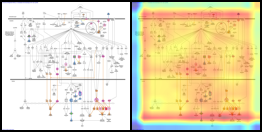

In [96]:
image_number = 1
torch_img = torch.tensor(np.expand_dims(test_x[image_number][0], 0)).to(device)
images = []
mask, _ = gradcam(torch_img)
heatmap, result = visualize_cam(mask, torch_img)
image0 = torch.squeeze(torch_img,dim=0)
images.extend([image0.cpu(), result])
grid_image = torchvision.utils.make_grid(images, nrow=2)
transforms.ToPILImage()(grid_image)

Finetuning

In [97]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096,out_features=2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [98]:

params_to_update = []
update_param_names = ['classifier.6.weight', 'classifier.6.bias']
for name, param in model.named_parameters():
    if name in update_param_names:
        param.requires_grad = True
        params_to_update.append(param)
        print(name)
    else:
        param.requires_grad = False

classifier.6.weight
classifier.6.bias


In [99]:

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=params_to_update, lr=0.001, momentum=0.9)




def train(train_loader):
    model.train()
    running_loss = 0
    correct = 0
    total = len(train_loader.dataset)

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        predicted = outputs.max(1, keepdim=True)[1]
        labels = labels.view_as(predicted)
        correct += predicted.eq(labels).sum().item()


    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    return train_loss, train_acc




def valid( test_loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = len(test_loader.dataset)
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = outputs.max(1, keepdim=True)[1]
            labels = labels.view_as(predicted)
            correct += predicted.eq(labels).sum().item()
            #break

    val_loss = running_loss / len(test_loader)
    val_acc = correct / total
    return val_loss, val_acc


acc_list = []
loss_list = []
val_loss_list = []
val_acc_list = []


In [100]:
nepoch = 50


for epoch in range(nepoch):

    if(epoch > 0):
        loss, acc = train(train_dataloader)
    else:
        loss, acc = valid(train_dataloader)

    val_loss, val_acc = valid(val_dataloader)
    print('epoch %d, loss: %.4f acc: %.4f val_loss: %.4f val_acc: %.4f' % (epoch, loss,acc, val_loss, val_acc))
    loss_list.append(loss)
    acc_list.append(acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)

epoch 0, loss: 0.7198 acc: 0.3714 val_loss: 0.7111 val_acc: 0.4000
epoch 1, loss: 0.7915 acc: 0.3714 val_loss: 0.7095 val_acc: 0.5500
epoch 2, loss: 0.8446 acc: 0.5429 val_loss: 0.6964 val_acc: 0.5500
epoch 3, loss: 0.5648 acc: 0.6143 val_loss: 0.9170 val_acc: 0.4500
epoch 4, loss: 0.7775 acc: 0.5000 val_loss: 1.1299 val_acc: 0.4500
epoch 5, loss: 0.8824 acc: 0.4857 val_loss: 0.8615 val_acc: 0.4500
epoch 6, loss: 0.9289 acc: 0.4714 val_loss: 0.6741 val_acc: 0.5500
epoch 7, loss: 1.0011 acc: 0.5429 val_loss: 0.6628 val_acc: 0.7500
epoch 8, loss: 0.6840 acc: 0.5571 val_loss: 0.9403 val_acc: 0.4500
epoch 9, loss: 0.8573 acc: 0.4857 val_loss: 0.7545 val_acc: 0.4500
epoch 10, loss: 0.5622 acc: 0.6143 val_loss: 0.7184 val_acc: 0.5500
epoch 11, loss: 1.2119 acc: 0.5429 val_loss: 0.6595 val_acc: 0.6000
epoch 12, loss: 0.6248 acc: 0.5286 val_loss: 0.6759 val_acc: 0.5000
epoch 13, loss: 0.7322 acc: 0.5857 val_loss: 0.6177 val_acc: 0.8000
epoch 14, loss: 0.7755 acc: 0.5429 val_loss: 0.7061 val_ac

In [101]:

torch.save(model, 'model_finetuning.pt')


Accuracy： 65.0 %


Text(0, 0.5, 'acc')

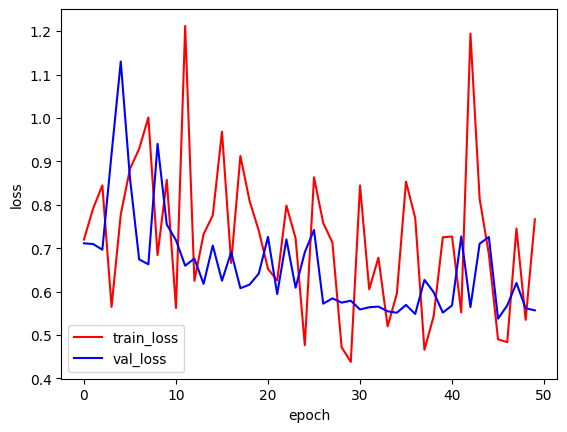

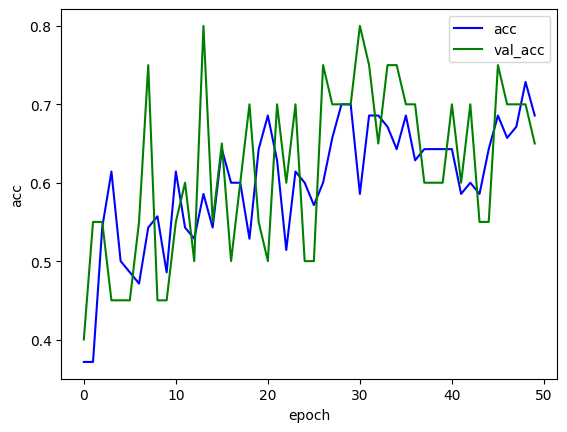

In [102]:
print('Accuracy：',val_acc_list[-1]*100, '%')

'''Results'''
plt.plot(range(nepoch), loss_list, 'r-', label='train_loss')
plt.plot(range(nepoch), val_loss_list, 'b-', label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

plt.figure()
plt.plot(range(nepoch), acc_list, 'b-', label='acc')
plt.plot(range(nepoch), val_acc_list, 'g-', label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')